In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

# Autoencoders

## Data

In [ ]:
def data_1():
  X = torch.randn(1000,3)
  a = 6
  X[0:250, 0] += a
  X[250:500, 1] += a
  X[500:750, 2] += a
  Y = torch.ones(1000, dtype=torch.long)
  Y[0:750] += 1
  Y[0:500] += 1
  Y[0:250] += 1
  # X = X.cuda()
  # Y = Y.cuda()
  return X, Y

def data_many_clusters(n_clus, n, m, sigma):
  X = sigma*torch.randn(n, m)
  Y = torch.zeros(n, dtype=torch.long)
  for i in range(n_clus):
    X[i*(n//n_clus):(i+1)*(n//n_clus)] += torch.randn(1, m)
    Y[i*(n//n_clus):(i+1)*(n//n_clus)] = i
  return X, Y

X, Y = data_many_clusters(10, 1000, 10, 0.3)

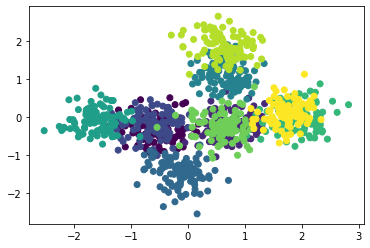

In [ ]:
plt.scatter(X[:,0].cpu(), X[:,1].cpu(), c=Y.cpu())

In [ ]:
c = []
for i in range(10):
  c.append(X[i*(1000//10):(i+1)*(100)].mean(0, keepdim=True))

In [ ]:
C = torch.cat(c)@torch.cat(c)

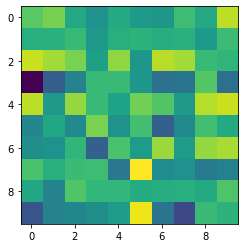

In [ ]:
plt.imshow(C)

## No Denoising

In [ ]:
encoder = torch.nn.Sequential(
    torch.nn.Linear(10, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 150),
    torch.nn.ReLU(),
    torch.nn.Linear(150, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 2),
)# .cuda()
decoder = torch.nn.Sequential(
    torch.nn.Linear(2, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 150),
    torch.nn.ReLU(),
    torch.nn.Linear(150, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 10),
)# .cuda()

In [ ]:
ds = torch.utils.data.TensorDataset(X, Y)

In [ ]:
dl = torch.utils.data.DataLoader(ds, batch_size=64)

In [ ]:
params = list(encoder.parameters()) + list(decoder.parameters())

In [ ]:
opt = torch.optim.Adamax(params, lr=0.001)

In [ ]:
loss = torch.nn.MSELoss()

In [ ]:
EPOCHS = 1000
pbar = trange(EPOCHS)
total_losses = [float('inf')]
for e in pbar:
  total_loss = 0
  for x, y in dl:
    opt.zero_grad()
    L = loss(decoder(encoder(x)), x)
    L.backward()
    opt.step()
    total_loss += L.item()
    pbar.set_description(f"Loss: {total_losses[-1]}")
  total_losses.append(total_loss)

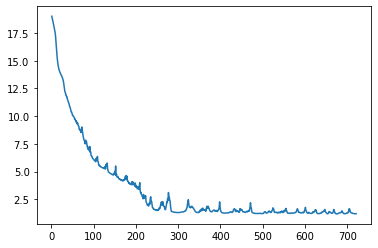

In [ ]:
plt.plot(total_losses)

In [ ]:
Z = encoder(X).detach().cpu()

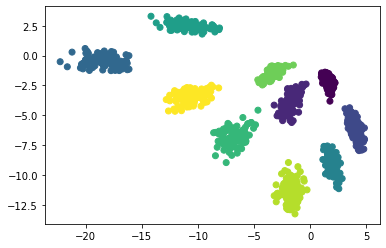

In [ ]:
plt.scatter(Z[:,0], Z[:,1], c=Y.cpu())

In [ ]:
Xhat = decoder(Z).detach()

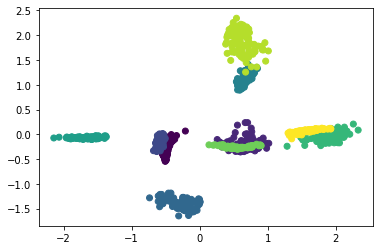

In [ ]:
plt.scatter(Xhat[:,0].cpu(), Xhat[:,1].cpu(), c=Y.cpu())

## With Denoising 

In [ ]:
encoder = torch.nn.Sequential(
    torch.nn.Linear(10, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 150),
    torch.nn.ReLU(),
    torch.nn.Linear(150, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 2),
)# .cuda()
decoder = torch.nn.Sequential(
    torch.nn.Linear(2, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 150),
    torch.nn.ReLU(),
    torch.nn.Linear(150, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 10),
)# .cuda()

In [ ]:
ds = torch.utils.data.TensorDataset(X, Y)

In [ ]:
dl = torch.utils.data.DataLoader(ds, batch_size=64)

In [ ]:
params = list(encoder.parameters()) + list(decoder.parameters())

In [ ]:
opt = torch.optim.Adamax(params, lr=0.001)

In [ ]:
loss = torch.nn.MSELoss()

In [ ]:
EPOCHS = 1000
pbar = trange(EPOCHS)
total_losses = [float('inf')]
for e in pbar:
  total_loss = 0
  for x, y in dl:
    opt.zero_grad()
    L = loss(decoder(encoder(x + 0.1*torch.randn(x.shape))), x)
    L.backward()
    opt.step()
    total_loss += L.item()
    pbar.set_description(f"Loss: {total_losses[-1]}")
  total_losses.append(total_loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

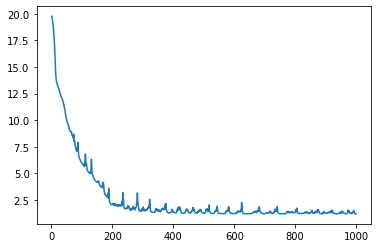

In [ ]:
plt.plot(total_losses)

In [ ]:
Z = encoder(X).detach()

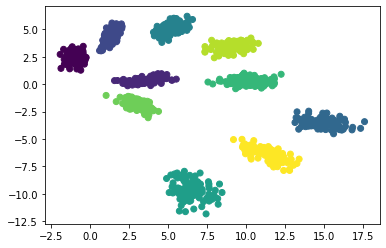

In [ ]:
plt.scatter(Z[:,0], Z[:,1], c=Y)

In [ ]:
Xhat = decoder(Z).detach()

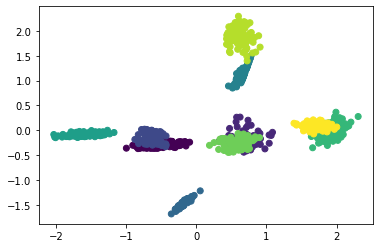

In [ ]:
plt.scatter(Xhat[:,0], Xhat[:,1], c=Y)

No change. Why? 

This is because only denoising doesn't solve any problem. The thing is that we have to also perturb the inner representations. (According to the original paper.)

# Denoising With Noise

In [ ]:
encoder = torch.nn.Sequential(
    torch.nn.Linear(10, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 150),
    torch.nn.ReLU(),
    torch.nn.Linear(150, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 2),
)# .cuda()
decoder = torch.nn.Sequential(
    torch.nn.Linear(2, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 150),
    torch.nn.ReLU(),
    torch.nn.Linear(150, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 10),
)# .cuda()

In [ ]:
ds = torch.utils.data.TensorDataset(X, Y)

In [ ]:
dl = torch.utils.data.DataLoader(ds, batch_size=64)

In [ ]:
params = list(encoder.parameters()) + list(decoder.parameters())

In [ ]:
opt = torch.optim.Adamax(params, lr=0.001)

In [ ]:
loss = torch.nn.MSELoss()

In [ ]:
EPOCHS = 1000
pbar = trange(EPOCHS)
total_losses = [float('inf')]
for e in pbar:
  total_loss = 0
  for x, y in dl:
    opt.zero_grad()
    Z = encoder(x + 0.8*torch.randn(x.shape))
    Z = Z + 0.1*Z.std(0)*torch.randn(Z.shape)
    L = loss(decoder(Z), x)
    L.backward()
    opt.step()
    total_loss += L.item()
    pbar.set_description(f"Loss: {total_losses[-1]}")
  total_losses.append(total_loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

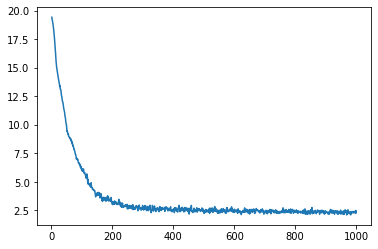

In [ ]:
plt.plot(total_losses)

In [ ]:
Z = encoder(X).detach()

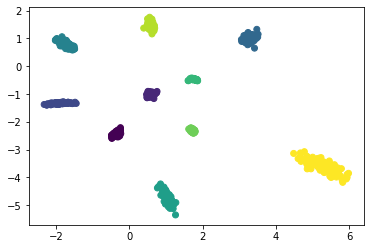

In [ ]:
plt.scatter(Z[:,0], Z[:,1], c=Y)

In [ ]:
Xhat = decoder(Z).detach()

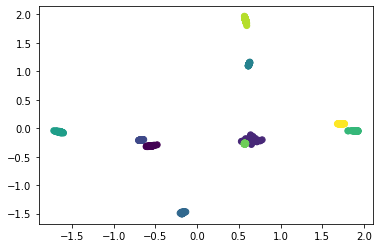

In [ ]:
plt.scatter(Xhat[:,0], Xhat[:,1], c=Y)